In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "BTC/USD" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime(2024, 5, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02 06:00:00+00:00,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03 06:00:00+00:00,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04 06:00:00+00:00,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05 06:00:00+00:00,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


## making a signal as a category 


<Axes: xlabel='timestamp'>

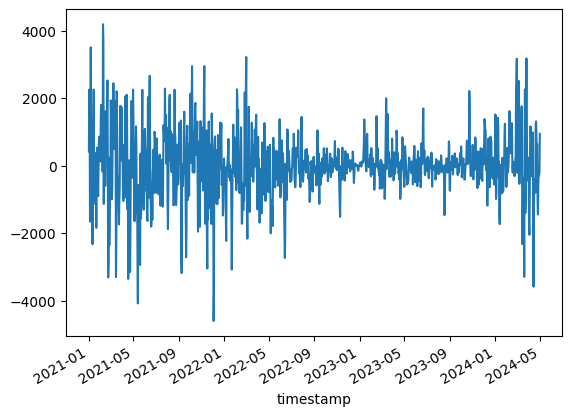

In [2]:
data["open_deri"] = np.gradient(data["open"].values, np.array(range(0, len(data))))
data["open_deri"].plot()

In [3]:
data["signal"] = 0 # NEUTRAL
data.loc[data["open_deri"] > 800, "signal"] = 2 # BUY
data.loc[data["open_deri"] < -800, "signal"] = 1 # SELL
data["signal"]

timestamp
2021-01-01 06:00:00+00:00    0
2021-01-02 06:00:00+00:00    2
2021-01-03 06:00:00+00:00    2
2021-01-04 06:00:00+00:00    1
2021-01-05 06:00:00+00:00    2
                            ..
2024-04-26 05:00:00+00:00    0
2024-04-27 05:00:00+00:00    0
2024-04-28 05:00:00+00:00    0
2024-04-29 05:00:00+00:00    0
2024-04-30 05:00:00+00:00    2
Name: signal, Length: 1216, dtype: int64

# making a model 

In [4]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1216 972 244


In [5]:
train_data.head()

,symbol,open,high,low,close,volume,trade_count,vwap,open_deri,signal
timestamp,,,,,,,,,,
2021-01-01 06:00:00+00:00,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625,422.630,0
2021-01-02 06:00:00+00:00,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694,2256.905,2
2021-01-03 06:00:00+00:00,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474,1614.510,2
2021-01-04 06:00:00+00:00,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121,-1653.840,1
2021-01-05 06:00:00+00:00,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357,1090.435,2


In [8]:
from sklearn.svm import LinearSVC

y = train_data["signal"].values
X = train_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values
model = LinearSVC()
model.fit(X, y)

/home/axel/Programs/repositories/cira-examples/env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/axel/Programs/repositories/cira-examples/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [9]:
model.predict(test_data.drop(columns=["signal", "open_deri", "symbol"], inplace=False).values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0])

## making it a strat 

In [ ]:
from cira.strategy import Strategy

class Clf(Strategy):
    def __init__(self) -> None:
        super().__init__("Clf")
        